In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/balanced_all_data_set.csv')
df

,Category,Unnamed: 0,Topic Title,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,distributed,0,About the distributed category,[],(Replace this first paragraph with a brief des...,"['Hi, smth, this is my (maybe almost) first co...","Dec 30, 2018 11:01 pm",0,701,1
1,distributed,1,Memory leak when using RPC for pipeline parall...,['distributed-rpc'],"Hi, when I use torch.distributed.rpc to implem...",['This looks interesting!\nI think firs you ne...,"Jul 20, 2021 5:39 am",0,75,11
2,distributed,2,Distributed Data Parallel example - “process 0...,[],I’m running Distributed Data Parallel example ...,[],0,0,0,0
3,distributed,3,How to use 8GPUs as 1,[],Hi I’m trying to do a learning a certain way a...,[],0,0,0,0
4,distributed,4,Disabling all reduce in Distributed Data Parallel,[],"Hello, I’m trying to setup distributed model t...",['\nIs it possible to disable this functionali...,"Jul 21, 2021 9:09 am",0,25,3
...,...,...,...,...,...,...,...,...,...,...
27742,uncategorized,9995,Pytorch conv_transpose2d and TF conv2d_trasnpose,NaN,I am converting a TF weight to Pytorch.\nI cop...,"[""Didn’t this one work?\n inp = F.pad(inp, [1...","Jul 5, 2018 6:51 am",0,708,1
27743,uncategorized,9996,(Cross entropy loss) accuracy on siamese net a...,NaN,I have a siamese network which I am training o...,['Can you please put your code here? Then we c...,"May 19, 2020 3:31 am",1,93,1
27744,uncategorized,9997,Torch.stack yielding wrong dimensions,NaN,"I am quite new to pytorch, and I am trying to ...","['Since you are passing two values to self.c, ...","May 18, 2020 3:47 pm",0,123,2
27745,uncategorized,9998,Set elements of a matrix prior to a specific i...,NaN,"Hi\nI have an index vector like:\nidx_v = [1,...",['This code should work:\nidx_v = torch.tensor...,"May 18, 2020 4:23 am",1,115,2


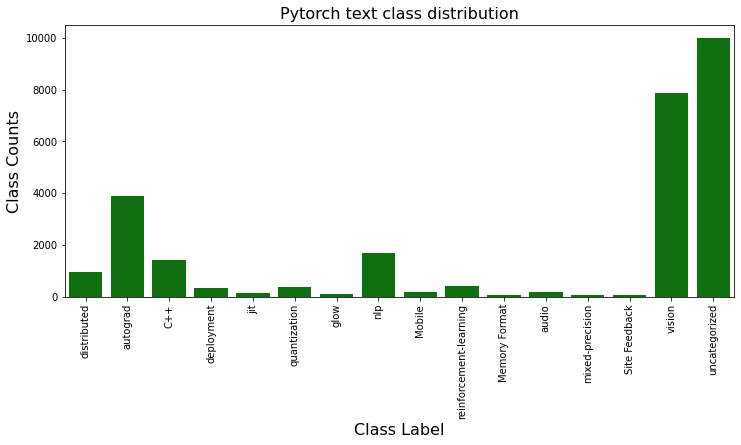

In [ ]:
# Data Exploration & Visualisation===========================================
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x = df.Category, color='green')
plt.title('Pytorch text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [ ]:
df.drop(columns= ['Unnamed: 0'], inplace=True)

In [ ]:
df_1 = df.copy()

In [ ]:
df_1['text'] = df_1['Topic Title'] + ' ' + df_1['Leading Post'] + ' ' + df_1['Post Replies']

In [ ]:
df_1

,Category,Topic Title,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies,text
0,distributed,About the distributed category,[],(Replace this first paragraph with a brief des...,"['Hi, smth, this is my (maybe almost) first co...","Dec 30, 2018 11:01 pm",0,701,1,About the distributed category (Replace this f...
1,distributed,Memory leak when using RPC for pipeline parall...,['distributed-rpc'],"Hi, when I use torch.distributed.rpc to implem...",['This looks interesting!\nI think firs you ne...,"Jul 20, 2021 5:39 am",0,75,11,Memory leak when using RPC for pipeline parall...
2,distributed,Distributed Data Parallel example - “process 0...,[],I’m running Distributed Data Parallel example ...,[],0,0,0,0,Distributed Data Parallel example - “process 0...
3,distributed,How to use 8GPUs as 1,[],Hi I’m trying to do a learning a certain way a...,[],0,0,0,0,How to use 8GPUs as 1 Hi I’m trying to do a le...
4,distributed,Disabling all reduce in Distributed Data Parallel,[],"Hello, I’m trying to setup distributed model t...",['\nIs it possible to disable this functionali...,"Jul 21, 2021 9:09 am",0,25,3,Disabling all reduce in Distributed Data Paral...
...,...,...,...,...,...,...,...,...,...,...
27742,uncategorized,Pytorch conv_transpose2d and TF conv2d_trasnpose,NaN,I am converting a TF weight to Pytorch.\nI cop...,"[""Didn’t this one work?\n inp = F.pad(inp, [1...","Jul 5, 2018 6:51 am",0,708,1,Pytorch conv_transpose2d and TF conv2d_trasnpo...
27743,uncategorized,(Cross entropy loss) accuracy on siamese net a...,NaN,I have a siamese network which I am training o...,['Can you please put your code here? Then we c...,"May 19, 2020 3:31 am",1,93,1,(Cross entropy loss) accuracy on siamese net a...
27744,uncategorized,Torch.stack yielding wrong dimensions,NaN,"I am quite new to pytorch, and I am trying to ...","['Since you are passing two values to self.c, ...","May 18, 2020 3:47 pm",0,123,2,Torch.stack yielding wrong dimensions I am qui...
27745,uncategorized,Set elements of a matrix prior to a specific i...,NaN,"Hi\nI have an index vector like:\nidx_v = [1,...",['This code should work:\nidx_v = torch.tensor...,"May 18, 2020 4:23 am",1,115,2,Set elements of a matrix prior to a specific i...


In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = str(s)
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
df_1.iloc[2,1]

'Distributed Data Parallel example - “process 0 terminated with exit code 1”'

In [ ]:
clean_text(df_1.iloc[2,1])

'distribut data parallel exampl “process termin exit code'

In [ ]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

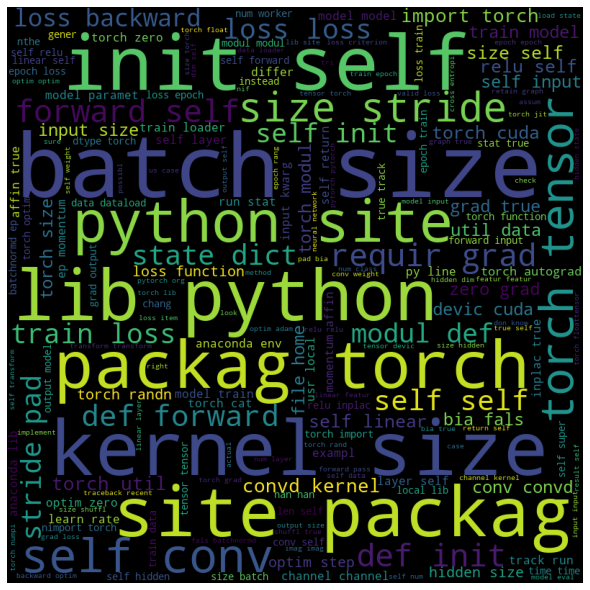

In [ ]:
texts = ''
for index, item in df_1.iterrows():
    texts = texts + ' ' + clean_text(item['text'])
    
plot_word_cloud(texts)

In [ ]:
df_1.rename(columns={"Category": "category"}, inplace=True)

In [ ]:
def plot_word_cloud_for_category(df_1, category):
    text_df = df_1.loc[df_1['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

In [ ]:
df_1.category.unique()

array(['distributed', 'autograd', 'C++', 'deployment', 'jit',
       'quantization', 'glow', 'nlp', 'Mobile', 'reinforcement-learning',
       'Memory Format', 'audio', 'mixed-precision', 'Site Feedback',
       'vision', 'uncategorized'], dtype=object)

In [ ]:
my_list = ['distributed', 'autograd', 'C++', 'deployment', 'jit',
       'quantization', 'glow', 'nlp', 'Mobile', 'reinforcement-learning',
       'Memory Format', 'audio', 'mixed-precision', 'Site Feedback',
       'vision', 'uncategorized']

In [ ]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
DIGITS_RE=re.compile('\w*\d\w*')

def clean_text(text):
    text = str(text)
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = DIGITS_RE.sub('', text)
    return text

df_1['text']=df_1['text'].apply(clean_text)


df_2 = df_1[df_1['category'].notna()]
df_2.category.unique()

df_x = df_2['text']
df_y = df_2['category']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Building the Machine Learning model & pipeline
#Converting to Doc2Vec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [ ]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 27747/27747 [00:00<00:00, 2547653.36it/s]


matrix([[-4.6159509e-01,  4.3083540e-01,  1.3804007e+00, ...,
         -4.2882633e-01,  9.0283269e-01,  1.7048160e+00],
        [-8.5049468e-01,  1.0494417e+00, -1.0321383e+00, ...,
         -1.3222871e+00,  7.0880514e-01, -2.9684775e+00],
        [ 2.7631361e-03, -2.3936541e-03,  1.8849055e-03, ...,
          1.8394340e-03, -1.9721207e-03, -4.8071616e-03],
        ...,
        [-7.7096623e-04, -3.9416067e-03, -6.8204023e-04, ...,
         -3.2278807e-03,  6.5041130e-04, -1.8081587e-03],
        [ 3.6660992e-03,  4.2804622e-05,  1.9969254e-04, ...,
         -1.8580146e-03,  5.4073293e-04,  2.1948724e-03],
        [ 1.1325746e-04, -9.3316303e-05,  1.4446123e-03, ...,
          3.2850858e-03, -3.7430867e-03,  1.4285642e-03]], dtype=float32)

In [ ]:
#Pipeline with Doc2Vec & LogisticRegression=================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 22197/22197 [00:00<00:00, 2578831.25it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 22197/22197 [00:00<00:00, 1641876.51it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 22198/22198 [00:00<00:00, 1669418.88it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 22198/22198 [00:00<00:00, 1468605.14it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coe

Accuracy for Logistic Regression:  0.35820091275272387


In [ ]:
#Pipeline with Doc2Vec & RandomForest=========================================

from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 22198/22198 [00:00<00:00, 1490612.71it/s]


Accuracy for RandomForest :  0.3349912962160214


In [ ]:
#Pipeline with Doc2Vec & XGBoost==============================================
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 22198/22198 [00:00<00:00, 1442685.64it/s]


Accuracy for XGBoost Classifier :  0.35708341248078135


In [ ]:
#Converting to Tf-Idf========================================================

from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [ ]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [ ]:
tfidf_vectors.shape

(27747, 262098)

In [ ]:
print(tfidf_vectors)

  (0, 255098)	0.022521472222922497
  (0, 254200)	0.05767945071840708
  (0, 244039)	0.03968982088315141
  (0, 239270)	0.029647315765770062
  (0, 228634)	0.1566498370954202
  (0, 225847)	0.04896337038543924
  (0, 215231)	0.052418431237199636
  (0, 214609)	0.11120722558170963
  (0, 210831)	0.0680985398972765
  (0, 209139)	0.04433328496011109
  (0, 207949)	0.0716695444818476
  (0, 187385)	0.07923789923665096
  (0, 184953)	0.058723374467033136
  (0, 182364)	0.11523717798576756
  (0, 176872)	0.05173103352919022
  (0, 162729)	0.07495104262891183
  (0, 160758)	0.055097356438170125
  (0, 159052)	0.0558471867478429
  (0, 156267)	0.10579376694298898
  (0, 156265)	0.09193087086808899
  (0, 155934)	0.06449031107101555
  (0, 138904)	0.043972139832994965
  (0, 138184)	0.09804323110583668
  (0, 136321)	0.027451375799658055
  (0, 126433)	0.07558656398701555
  :	:
  (27746, 123550)	0.06485388283925582
  (27746, 115558)	0.119559228897715
  (27746, 113825)	0.07440822442597148
  (27746, 106365)	0.041674632

In [ ]:
#Pipeline with Tf-Idf & LogisticRegression==================================

pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.5778287005693745


In [ ]:
#Pipeline with Tf-Idf & RandomForest=========================================

pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                          ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.5496810041254084


In [ ]:
#Pipeline with Tf-Idf & XGBoost================================================
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.5858645677575215
